In [4]:
%matplotlib ipympl
import os
import time
import pandas
import traceback
from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
from onix.helpers import present_float
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile
import allantools
from tqdm import tqdm
from uncertainties import ufloat, unumpy
from scipy.stats import pearsonr
from allantools import adev
from scipy.interpolate import interp1d

In [5]:
def phase_fit(phi, A, B, C, phi_0):
    return A * np.cos(phi - phi_0) +  B * phi + C

def get_phase_fitter(phases, heights, height_errs):
    fitter = Fitter(phase_fit)
    fitter.set_data(phases, heights, height_errs)
    fitter.set_bounds("A", 0, np.inf)

    # setting this bound makes weird fits for certain phi_0's because they want to fit to a value outside the bound
    # fitter.set_bounds("phi_0", 0, 2*np.pi)
    fitter.fit()
    return fitter


In [6]:
def data_identification_to_list(data_identification):
    if isinstance(data_identification, tuple):
        return range(data_identification[0], data_identification[1] + 1)
    elif isinstance(data_identification, int):
        return [data_identification]
    else:
        # it should be a list
        return data_identification

In [7]:
def get_normalized_transmission(data_number):
    data, header = get_experiment_data(data_number)
    detunings_MHz = header["detunings"].to("MHz").magnitude
    transmissions_avg, transmissions_err = group_and_average_data(data["transmissions_avg"], header["params"]["detect"]["cycles"], return_err=True)
    monitors_avg, monitors_err = group_and_average_data(data["monitors_avg"], header["params"]["detect"]["cycles"], return_err=True)
    normalized_avg = {}
    for kk in transmissions_avg:
        if transmissions_avg[kk].ndim >= 1:
            normalized_avg[kk] = unumpy.uarray(
                np.average(transmissions_avg[kk] / monitors_avg[kk]),
                np.average(np.sqrt(
                    (transmissions_err[kk] / monitors_avg[kk]) ** 2
                    + (transmissions_avg[kk] * monitors_err[kk] / monitors_avg[kk]) ** 2
                ))
            )
        else:
            normalized_avg[kk] = ufloat(
                transmissions_avg[kk] / monitors_avg[kk],
                np.sqrt(
                    (transmissions_err[kk] / monitors_avg[kk]) ** 2
                    + (transmissions_avg[kk] * monitors_err[kk] / monitors_avg[kk]) ** 2
                )
            )
    return detunings_MHz, normalized_avg, header

# detunings_MHz, normalized_avg, header = get_normalized_transmission(2152647) #2149070 2152647
# print(normalized_avg)

In [8]:
def get_experiment_result(data_number):
    detunings, data, header = get_normalized_transmission(data_number)
    total_pop_1 = 1#data["1"] - data["2"]
    pop_other_state_1 = -data["3"]#data["1"] - data["3"]
    total_pop_2 = 1#data["4"] - data["5"]
    pop_other_state_2 = -data["6"]#data["4"] - data["6"]
    # print(total_pop_1, total_pop_2)
    return (header, pop_other_state_1 + pop_other_state_2, total_pop_1 + total_pop_2)

In [9]:
def get_results(data_identification):
    data_list = data_identification_to_list(data_identification)
    headers = []
    results = []
    for data_number in data_list:
        header, pop_other_state, total_pop = get_experiment_result(data_number)
        headers.append(header)
        results.append(pop_other_state / total_pop)
    return headers, np.array(results)

In [10]:
def averaging_ys(xs, ys):
    xs_unique = np.unique(xs)
    ys_to_avg = [[] for _ in range(len(xs_unique))]
    for x, y in zip(xs, ys):
        ys_to_avg[np.argwhere(xs_unique == x)[0][0]].append(y)
    ys_avg = []
    ys_std = []
    for y_list in ys_to_avg:
        ys_avg.append(np.average(y_list))
        ys_std.append(np.std(y_list))
    ys_avg = np.array(ys_avg)
    ys_std = np.array(ys_std)
    
    return xs_unique, ys_avg, ys_std

    #cleaner
    
#    xs = list(set(xs_dupe))
#    ys = [np.average([ys_dupe[i] for i in range(len(ys_dupe)) if xs_dupe[i] == xs[j]]) for j in range(len(xs))]
#    ys_err = [np.std([ys_dupe[i] for i in range(len(ys_dupe)) if xs_dupe[i] == xs[j]]) for j in range(len(xs))]

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

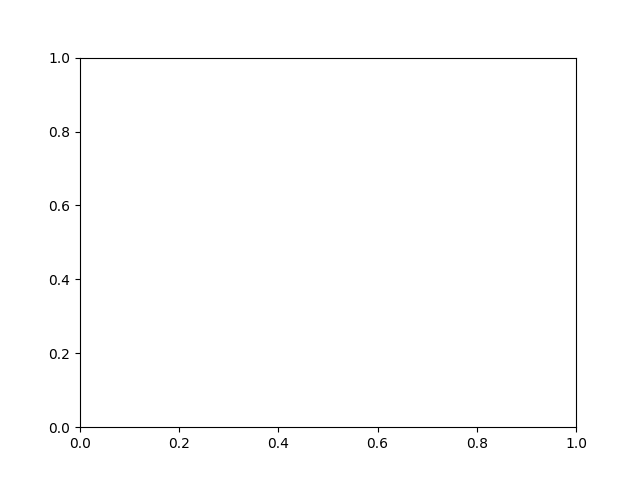

In [11]:
data_numbers = {
    "0.2 s sleep, optical 1000, 0 MHz, probe 0 MHz, 40 us x 128": (2148363, 2148662),
    "0.2 s sleep, optical 500, 0 MHz, probe 0 MHz, 40 us x 128": (2148676, 2148835),
}

fig, ax = plt.subplots()
for ll, (label, data_range) in enumerate(data_numbers.items()):
    xs_dupe = []
    ys_dupe = []
    ys2_dupe = []
    ys3_dupe = []
    for data_number in range(data_range[0], data_range[1]+1):
        detunings, data, header = get_normalized_transmission(data_number)
        xs_dupe.append(header["params"]["optical"]["this_duration"].to("us").magnitude)
        ys2_dupe.append((data["2"][0] - data["1"][0]).nominal_value)
        ys3_dupe.append((data["3"][0] - data["1"][0]).nominal_value)
        ys_dupe.append(ys3_dupe[-1] / ys2_dupe[-1])

    xs = list(set(xs_dupe))
    ys = [np.average([ys_dupe[i] for i in range(len(ys_dupe)) if xs_dupe[i] == xs[j]]) for j in range(len(xs))]
    ys_err = [np.std([ys_dupe[i] for i in range(len(ys_dupe)) if xs_dupe[i] == xs[j]]) for j in range(len(xs))]
    
    ax.errorbar(xs, ys, ys_err, ls="", marker="o")
ax.set_xlabel("Duration (us)")
ax.set_ylabel("Normalized transmission (V/V)")
plt.show()

#### data_numbers = {
    "50 us, shorter detect": (2151421, 2151540),
    "100 us, shorter detect": (2151560, 2152159),
    "200 us, shorter detect": (2152173, 2152332),
}

fig, ax = plt.subplots()
for ll, (label, data_range) in enumerate(data_numbers.items()):
    xs_dupe = []
    ys_dupe = []
    ys2_dupe = []
    ys3_dupe = []
    for data_number in range(data_range[0], data_range[1]+1):
        detunings, data, header = get_normalized_transmission(data_number)
        xs_dupe.append(header["params"]["optical"]["this_amplitude"])
        ys2_dupe.append((data["2"][0] - data["1"][0]).nominal_value)
        ys3_dupe.append((data["3"][0] - data["1"][0]).nominal_value)
        ys_dupe.append(ys3_dupe[-1] / ys2_dupe[-1])

    xs = list(set(xs_dupe))
    ys = [np.average([ys_dupe[i] for i in range(len(ys_dupe)) if xs_dupe[i] == xs[j]]) for j in range(len(xs))]
    ys_err = [np.std([ys_dupe[i] for i in range(len(ys_dupe)) if xs_dupe[i] == xs[j]]) for j in range(len(xs))]
    
    ax.errorbar(xs, ys, ys_err, ls="", marker="o", label=label)
ax.set_xlabel("rf AWG amplitude to double-pass AOM")
ax.set_ylabel("Normalized transmission (V/V)")
ax.legend()
plt.tight_layout()
plt.show()

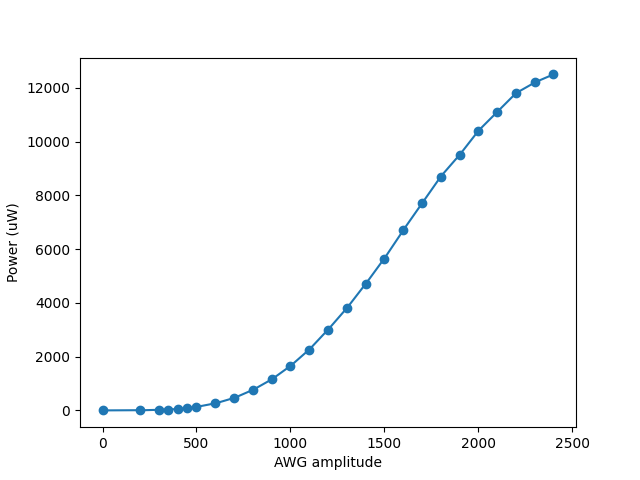

In [13]:
## AWG interpolation amplitude -> power
amplitudes = 100. * np.array([0, 2, 3, 3.5, 4, 5, 4.5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16 ,17, 18, 19, 20, 21, 22, 23, 24])
powers_uW = np.array([0, 4, 20, 31, 54, 130, 80, 260, 460, 760, 1150, 1650, 2260, 3000, 3800, 4700, 5650, 6700, 7700, 8700, 9500, 10400, 11100, 11800, 12200, 12500])

amplitude_to_uW = interp1d(amplitudes, powers_uW)

interp_xs = np.linspace(np.min(amplitudes), np.max(amplitudes), 1000)
interp_ys = amplitude_to_uW(interp_xs)


fig, ax = plt.subplots()
ax.scatter(amplitudes, powers_uW)
ax.plot(interp_xs, interp_ys)
ax.set_ylabel("Power (uW)")
ax.set_xlabel("AWG amplitude")
plt.show()


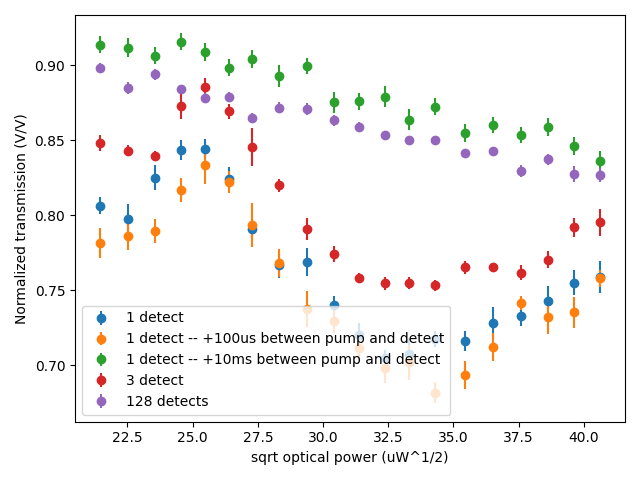

In [70]:
data_numbers = {
    # "50 us, shorter detect": (2151421, 2151540),
    # "100 us, shorter detect": (2151560, 2152159),
    # "200 us, shorter detect": (2152173, 2152332),

    # "10 us": (2149070, 2149209),
    # "20 us": (2149277, 2149496),
    # "30 us": (2149502, 2149641),
    # "40 us": (2149659, 2149858),
    # "60 us": (2149862, 2150021),
    # "80 us": (2150030, 2150209),
    # "100 us": (2150219, 2150378),
    # "150 us": (2150382, 2150581),
    # "200 us": (2150591, 2150810),

    ### 16 detections, 40 detunings from -1 to 1 MHz
    # "optical duration 10 us": (2152647, 2152706),

    
    ### 3 detections, 40 detunings from -1 to 1 MHZ
    # "optical duration 10 us": (2152353, 2152612),
    # "optical duration 20 us": (2152758, 2153117),
    # "optical duration 30 us": (2153130, 2153349),
    # "optical duration 40 us": (2153371, 2153570),
    # "optical duration 200 us": (2153579, 2153758),

    ### 3 detections, 0 MHz detuning
    # "optical duration 180 us": (2157389, 2157608),
    # "optical duration 140 us": (2158370, 2158729),

    ### optical duration 200 us, scanning detect detunings range; using detunings = np.arange(X, Y, 0.05) MHz
    # "-1 to 1 MHz": (2153783, 2153982),
    # "-0.5 to 0.5 MHz": (2153991, 2154170),
    # "-0.2 to 0.2 MHz": (2154627, 2154966),
    # "-0.1 to 0.1 MHz": (2154186, 2154325), 
    # "-0.05 to 0.05 MHz": (2154355, 2154614), 
    # "0 MHz": (2154977, 2155256),
    

    ### finer scans, detect = [0 MHz], 3 detects
    # "200 us optical duration from awg 700-1000": (2156050, 2157109),
    # "180 us optical duration from awg 700-1000": (2157698, 2157937), 
    # "140 us optical duration from awg 700-1000": (2157975, 2158174), 
    # "140 us optical duration from awg 400-700": (2158752, 2159371),
    # "100 us optical duration from awg 700-1000": (2159387, 2159506),



    ## scanning number of detects, 100 us, awg 700-1000
    "1 detect": (2159927, 2160186),
    "1 detect -- +100us between pump and detect": (2160421, 2160600),
    "1 detect -- +10ms between pump and detect": (2160613, 2161772),
    "3 detect": (2159387, 2159506),
    "128 detects": (2159716, 2159855),


}

fig, ax = plt.subplots()
for ll, (label, data_range) in enumerate(data_numbers.items()):
    xs_dupe = []
    ys_dupe = []
    ys2_dupe = []
    ys3_dupe = []
    for data_number in range(data_range[0], data_range[1]+1):
        detunings, data, header = get_normalized_transmission(data_number)
        # print(data)
        xs_dupe.append(header["params"]["optical"]["this_amplitude"])
        ys2_dupe.append((data["2"] - data["1"]).nominal_value)
        ys3_dupe.append((data["3"] - data["1"]).nominal_value)
        ys_dupe.append(ys3_dupe[-1] / ys2_dupe[-1])

    xs = list(set(xs_dupe))
    ys = [np.average([ys_dupe[i] for i in range(len(ys_dupe)) if xs_dupe[i] == xs[j]]) for j in range(len(xs))]
    ys_std = [np.std([ys_dupe[i] for i in range(len(ys_dupe)) if xs_dupe[i] == xs[j]]) for j in range(len(xs))]
    
    N = len([ys_dupe[i] for i in range(len(ys_dupe)) if xs_dupe[i] == xs[0]])
    ys_err = ys_std / np.sqrt(N)
    
    ax.errorbar(np.sqrt(amplitude_to_uW(xs)), ys, ys_err, ls="", marker="o", label=label)
    # ax.errorbar(xs, ys, ys_err, ls="", marker="o", label=label)


ax.set_xlabel("sqrt optical power (uW^1/2)")
# ax.set_xlabel("awg amplitude")
ax.set_ylabel("Normalized transmission (V/V)")
ax.legend()
plt.tight_layout()
plt.show()